In [1]:
# See requirements.txt to set up your dev environment.
import sys
import os
import json
import scipy
import urllib
import datetime 
import urllib3
import rasterio
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from osgeo import gdal
from planet import api
from planet.api import filters
from traitlets import link
import rasterio.tools.mask as rio_mask
from shapely.geometry import mapping, shape
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from scipy import ndimage
urllib3.disable_warnings()
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

%matplotlib inline
# will pick up api_key via environment variable PL_API_KEY
# but can be specified using `api_key` named argument
api_keys = json.load(open("apikeys.json",'r'))
client = api.ClientV1(api_key=api_keys["PLANET_API_KEY"])

In [2]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + api_keys["PLANET_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [45.5231, -122.6765]
# Define initial map zoom level
zoom = 11
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

In [3]:
areaAOI = AOIs[1]["geometry"]
pathAOI = AOIs[2]["geometry"]

aoi_file ="portland.geojson" 
with open(aoi_file,"w") as f:
    f.write(json.dumps(areaAOI))
# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes

old = datetime.datetime(year=2017,month=1,day=1)

query = filters.and_filter(
    filters.geom_filter(areaAOI),
    filters.range_filter('cloud_cover', gt=0),
    filters.date_range('acquired', gt=old)
)

# build a request for only PlanetScope imagery
request = filters.build_search_request(
    query, item_types=['PSScene3Band']
)

# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=500):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
display(scenes)
print len(scenes)

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:334: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


,acquired,anomalous_pixels,cloud_cover,columns,epsg_code,geometry,ground_control,gsd,id,instrument,...,quality_category,rows,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle
0,2017-04-27T18:15:08.760429Z,0.56,0.84,9215,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.988942,20170427_181508_102e,PS2,...,test,4766,102e,482975,133.4,50.5,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-29T17:52:11Z,0,0.2
1,2017-04-27T18:15:07.721087Z,0.29,0.63,9209,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.987969,20170427_181507_102e,PS2,...,test,4766,102e,482975,133.5,50.5,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-29T17:20:24Z,0,0.1
2,2017-04-27T18:15:06.681745Z,0.23,0.53,9209,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.986751,20170427_181506_102e,PS2,...,standard,4763,102e,482975,133.6,50.5,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-29T16:53:57Z,0,0.2
3,2017-04-28T18:13:37.682053Z,0.67,0.77,9668,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,4.176536,20170428_181337_1009,PS2,...,test,4911,1009,484242,133.4,50.7,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-29T15:52:40Z,0,0.4
4,2017-04-28T18:13:38.739796Z,0.64,0.77,9633,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,4.161517,20170428_181338_1009,PS2,...,test,4903,1009,484242,133.3,50.7,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-29T14:35:42Z,0,0.4
5,2017-04-28T18:13:39.797539Z,0.72,0.83,9596,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,4.146080,20170428_181339_1009,PS2,...,test,4894,1009,484242,133.2,50.8,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-29T13:54:17Z,0,0.5
6,2017-04-18T18:13:54.657796Z,0.32,0.59,9094,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.942415,20170418_181354_0f25,PS2,...,test,4653,0f25,471379,135.2,47.7,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-19T08:43:54Z,0,0.7
7,2017-04-18T18:13:53.601975Z,0.15,0.46,9093,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.942612,20170418_181353_0f25,PS2,...,test,4654,0f25,471379,135.3,47.6,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-19T08:12:00Z,0,0.7
8,2017-04-18T18:13:52.546154Z,0.17,0.47,9094,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.942577,20170418_181352_0f25,PS2,...,standard,4653,0f25,471379,135.4,47.6,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-19T07:25:56Z,0,0.7
9,2017-04-18T00:30:18.876098Z,0.00,0.22,4835,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,2.974284,20170418_003018_0c75,PS2,...,standard,6752,0c75,470582,259.3,25.4,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-18T20:48:33Z,0,1.4


66


In [ ]:
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(areaAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])
scenes.head()

In [ ]:
scenes[0:3]

In [6]:
def get_products(client, scene_id, asset_type='PSScene3Band'):    
    """
    Ask the client to return the available products for a 
    given scene and asset type. Returns a list of product 
    strings
    """
    out = client.get_assets_by_id(asset_type,scene_id)
    temp = out.get()
    return temp.keys()

def activate_product(client, scene_id, asset_type="PSScene3Band",product="analytic"):
    """
    Activate a product given a scene, an asset type, and a product.
    
    On success return the return value of the API call and an activation object
    """
    temp = client.get_assets_by_id(asset_type,scene_id)  
    products = temp.get()
    if( product in products.keys() ):
        return client.activate(products[product]),products[product]
    else:
        return None 

def download_and_save(client,product):
    """
    Given a client and a product activation object download the asset. 
    This will save the tiff file in the local directory and return its 
    file name. 
    """
    out = client.download(product)
    fp = out.get_body()
    fp.write()
    return fp.name

def scenes_are_active(scene_list):
    """
    Check if all of the resources in a given list of
    scene activation objects is read for downloading.
    """
    retVal = True
    for scene in scene_list:
        if scene["status"] != "active":
            print "{} is not ready.".format(scene)
            return False
    return True
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])
        
def load_image3(filename):
    """Return a 3D (r, g, b) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([b, g, r])
        
def get_mask(filename):
    """Return a 1D mask numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([mask])

def rgbir_to_rgb(img_4band):
    """Convert an RGBIR image to RGB"""
    return img_4band[:,:,:3]

In [ ]:
to_get = scenes["id"][0:3].tolist()
activated = []
# for each scene to get
for scene in to_get:
    # get the product 
    product_types = get_products(client,scene)
    for p in product_types:
        # if there is a visual product
        if p == "visual": # p == "basic_analytic_dn"
            print "Activating {0} for scene {1}".format(p,scene)
            # activate the product
            _,product = activate_product(client,scene,product=p)
            activated.append(product)

In [ ]:
tiff_files = []
asset_type = "_3B_Visual"
# check if our scenes have been activated
if scenes_are_active(activated):
    for to_download,name in zip(activated,to_get):
        # create the product name
        name = name + asset_type + ".tif"
        # if the product exists locally
        if( os.path.isfile(name) ):
            # do nothing 
            print "We have scene {0} already, skipping...".format(name)
            tiff_files.append(name)
        elif to_download["status"] == "active":
            # otherwise download the product
            print "Downloading {0}....".format(name)
            fname = download_and_save(client,to_download)
            tiff_files.append(fname)
            print "Download done."
        else:
            print "Could not download, still activating"
else:
    print "Scenes aren't ready yet"

print tiff_files 

In [4]:
tiff_files = ["20170319_182053_0e14_3B_Visual.tif","20170213_181923_0e14_3B_Visual.tif","20161206_181625_0e19_3B_Visual.tif" ]
commands = ["gdalwarp", # t
           "-t_srs","EPSG:3857",
           "-cutline",aoi_file,
           "-crop_to_cutline",
           "-tap",
            "-tr", "3", "3"
           "-overwrite"]
output_mosaic = "portland_mosaic.tif"
for tiff in tiff_files:
    commands.append(tiff)
commands.append(output_mosaic)
print " ".join(commands)
subprocess.call(commands)

gdalwarp -t_srs EPSG:3857 -cutline portland.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20170319_182053_0e14_3B_Visual.tif 20170213_181923_0e14_3B_Visual.tif 20161206_181625_0e19_3B_Visual.tif portland_mosaic.tif


0

(5974, 15926, 3)


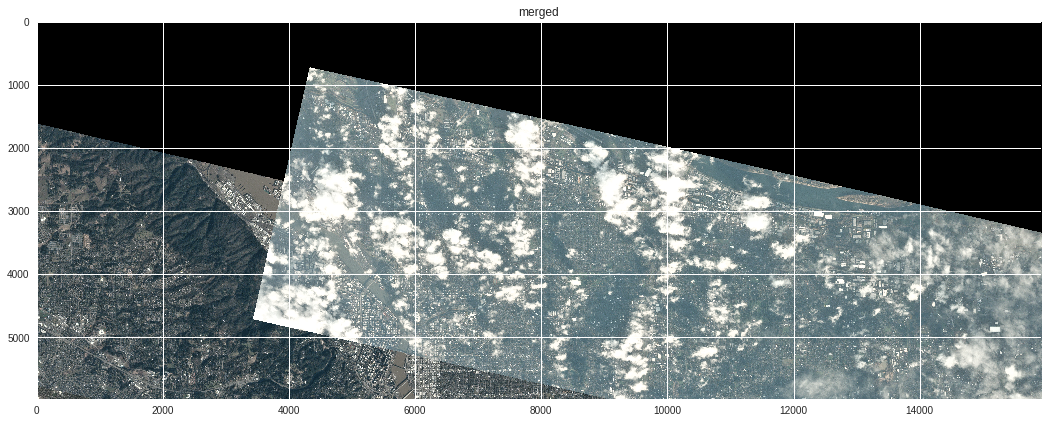

In [7]:
merged = load_image3(output_mosaic)
print merged.shape
plt.figure(0,figsize=(18,18))
plt.imshow(merged)
plt.title("merged")

In [9]:
def crop_to_area(scene,x_c,y_c,w,h):
    tlx = x_c-(w/2)
    tly = y_c-(h/2)
    brx = x_c+(w/2)
    bry = y_c+(h/2)
    return scene[tly:bry,tlx:brx,:]

In [ ]:
plt.figure(0,figsize=(3,4))
plt.imshow(crop_to_area(merged,3000,3000,640,480))
plt.title("merged")

In [10]:
from osgeo import gdal,ogr,osr
#https://gis.stackexchange.com/questions/57834/how-to-get-raster-corner-coordinates-using-python-gdal-bindings
def GetExtent(gt,cols,rows):
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print x,y
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

raster=output_mosaic
ds=gdal.Open(raster)

gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
ext=GetExtent(gt,cols,rows)

src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(ds.GetProjection())
#tgt_srs=osr.SpatialReference()
#tgt_srs.ImportFromEPSG(4326)
tgt_srs = src_srs.CloneGeogCS()

extents = ReprojectCoords(ext,src_srs,tgt_srs)
print extents

-13672854.0 5719098.0
-13672854.0 5701176.0
-13625076.0 5701176.0
-13625076.0 5719098.0
[[-122.82533725734733, 45.61645838263286], [-122.82533725734733, 45.50373531137708], [-122.39614018090069, 45.50373531137708], [-122.39614018090069, 45.61645838263286]]


In [11]:
def poor_mans_lat_lon_2_pix(lon,lat,w,h,extents):
    lats = [e[1] for e in extents]
    lons = [e[0] for e in extents]
    lat_max = np.max(lats)
    lat_min = np.min(lats)    
    lon_max = np.max(lons)
    lon_min = np.min(lons)    
    lat_diff = lat-lat_min
    lon_diff = lon-lon_min
    lat_r = float(h)/(lat_max-lat_min)
    lon_r = float(w)/(lon_max-lon_min)    
    return int(lat_r*lat_diff),int(lon_r*lon_diff)

h,w,c = merged.shape
print w,h
print poor_mans_lat_lon_2_pix(-122.7,45.56505,w,h,extents)
print poor_mans_lat_lon_2_pix(-122.67,45.56505,w,h,extents)
print poor_mans_lat_lon_2_pix(-122.67,45.6,w,h,extents)
print poor_mans_lat_lon_2_pix(-122.67,45.48,w,h,extents)

15926 5974
(3249, 4650)
(3249, 5764)
(5101, 5764)
(-1257, 5764)


[(5428, 255), (5402, 3338), (1148, 3465), (995, 12510), (4664, 12409), (4791, 14574)]


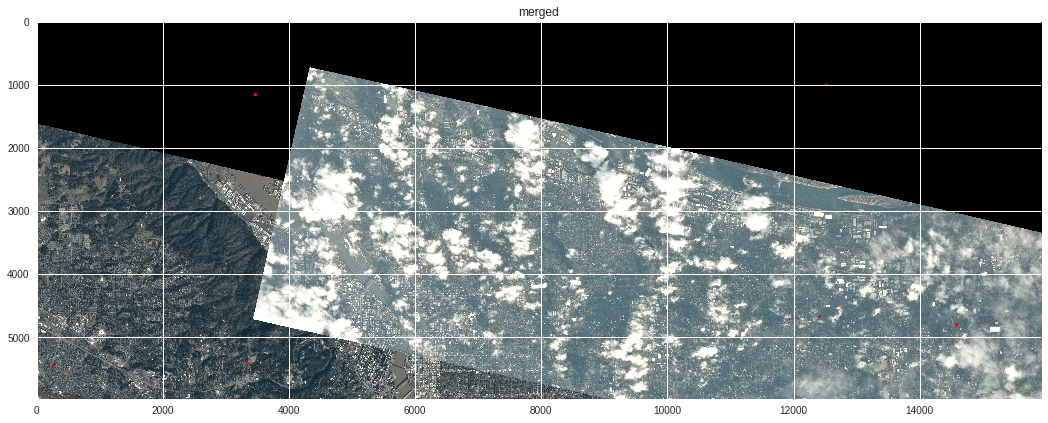

In [12]:
waypoints = [poor_mans_lat_lon_2_pix(point[0],point[1],w,h,extents) for point in pathAOI["coordinates"]]
print waypoints
def draw_point(x,y,img):
    t = 20
    img[y-t:y+t,x-t:x+t,:] = [255,0,0]
merged = load_image3(output_mosaic)
[draw_point(pt[1],pt[0],merged) for pt in waypoints]
plt.figure(0,figsize=(18,18))
plt.imshow(merged)
plt.title("merged")

In [ ]:
# this works but it isn't quite right
# Need to map lat lon to pixel
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform
# Read raster
with rasterio.open(output_mosaic) as r:
    T0 = r.affine  # upper-left pixel corner affine transform
    print r.crs
    p1 = Proj(r.crs)
    A = r.read_band(1)  # pixel values

# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[1]), np.arange(A.shape[0]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)
longs[0]

In [ ]:
ll = Proj(proj='latlong', datum='WGS84')
native = p1

x,y = transform(ll,native,-122.68,45.5)
print x,y

In [ ]:
x = int(inv_geometrix[0] + inv_geometrix[1] * X + inv_geometrix[2] * Y)
y = int(inv_geometrix[3] + inv_geometrix[4] * X + inv_geometrix[5] * Y)

In [ ]:
from osgeo import gdal,ogr
from osgeo.gdalconst import *
import struct
import sys

lon = -122.721
lat = 45.604

def pt2fmt(pt):
	fmttypes = {
		GDT_Byte: 'B',
		GDT_Int16: 'h',
		GDT_UInt16: 'H',
		GDT_Int32: 'i',
		GDT_UInt32: 'I',
		GDT_Float32: 'f',
		GDT_Float64: 'f'
		}
	return fmttypes.get(pt, 'x')

ds = gdal.Open(output_mosaic, GA_ReadOnly)

#cols = ds.RasterXSize
#rows = ds.RasterYSize
#bands = ds.RasterCount #1
#band = ds.GetRasterBand(1)
#bandtype = gdal.GetDataTypeName(band.DataType) #Int16
#driver = ds.GetDriver().LongName #'GeoTIFF'

transf = ds.GetGeoTransform()
transfInv = gdal.InvGeoTransform(transf)
inv_geometrix = transfInv
print transfInv
x = int(inv_geometrix[0] + inv_geometrix[1] * lat + inv_geometrix[2] * lon)
y = int(inv_geometrix[3] + inv_geometrix[4] * lat + inv_geometrix[5] * lon)


px, py = gdal.ApplyGeoTransform(transfInv, lon, lat)
print px,py
#structval = band.ReadRaster(int(px), int(py), 1,1, buf_type = band.DataType )
#fmt = pt2fmt(band.DataType)
#print structval
#intval = struct.unpack(fmt , structval)
#print round(intval[0],2) #intval is a tuple, length=1 as we only asked for 1 pixel value